### Downloading the packages - fastai , duckduckgo_search 

In [1]:
!pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 96 kB 5.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


### Custom function to search for images and get their urls

* **L()** - alternative to list in fastapi - 🔖[more about L](https://riven314.github.io/2020/04/26/l_vs_list.html)
* **ddg_images()** - returns a list of dicts with various attributes like title, image, thumbnail etc.


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images = 30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [7]:
urls = search_images("bengal tigers", max_images = 1)
urls[0]

Searching for 'bengal tigers'


'http://blog.waynebeauregard.com/blog/wp-content/uploads/2017/07/Bengal-Tiger.jpg'

### Displaying the downloaded image

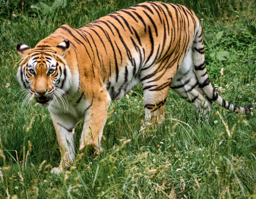

In [8]:
from fastdownload import download_url
dest = 'bengal_tiger.jpg'  # path to store images
download_url(urls[0], dest, show_progress=False) #downloads the url to the path

from fastai.vision.all import *
im = Image.open(dest) #reading the image
im.to_thumb(256,256) #displaying the resized image as thumbnai

Searching for 'lion photos'


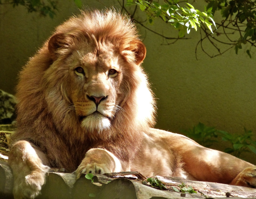

In [9]:
#Shorthand to download lion images and display it
download_url(search_images('lion photos', max_images = 1)[0], 'lion.jgp', show_progress = False)
Image.open('lion.jgp').to_thumb(256, 256)

### Downloading the dataset through the web

Here, we use all the eariler helper functions to create folder with different classes

* **download_images()** - Download images listed in text file ***url_file*** to ***path dest*** at most ***max_pics***

* **dest.mkdir()** - to make a directory at the given ***path***

In [10]:
searches = "tiger", 'lion'
path = Path('lion_or_tiger')
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents= True)
  download_images(dest, urls = search_images(f'{o} photo'))
  sleep(10)
  download_images(dest, urls = search_images(f'{o} sun photo'))
  sleep(10)
  download_images(dest, urls = search_images(f'{o} shade photo'))
  sleep(10)
  resize_images(path/o, max_size=400, dest = path/o)

Searching for 'tiger photo'
Searching for 'tiger sun photo'
Searching for 'tiger shade photo'
Searching for 'lion photo'
Searching for 'lion sun photo'
Searching for 'lion shade photo'


#### To remove corrupted images

* **verify_images(fns)** - Find images in fns that can't be opened
* **unlink()** - removes (deletes) the file path

In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


3

### Converting dataset into a datablock

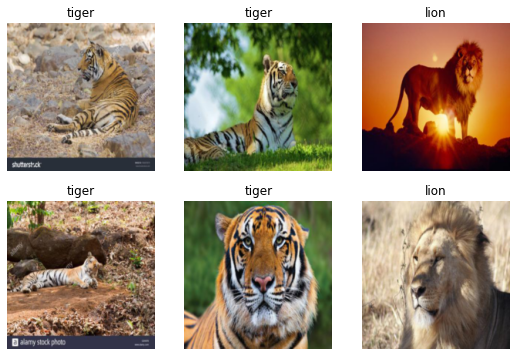

In [14]:
dls = DataBlock(
			blocks = ( ImageBlock, CategoryBlock), #(data type, # output type)
			get_items = get_image_files, #Where to get the images from
			splitter = RandomSplitter(valid_pct = 0.2, seed = 42), #splitting validation set
			get_y = parent_label, #ground truth
			item_tfms = [Resize(192, method = 'squish')]	#transformation applied to the images
).dataloaders(path, bs = 32) # loads the data from datablock 

dls.show_batch(max_n = 6)

### Transfer Learning 

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.820074,0.128710,0.029412,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.107456,0.092779,0.058824,00:29
1,0.066046,0.103031,0.058824,00:27
2,0.043275,0.113048,0.058824,00:35


### Prediction

In [19]:
is_tiger,_,probs = learn.predict(PILImage.create('bengal_tiger.jpg')) #returns class number, class_int, classes_prob
print(f"This is a: {is_tiger}.")
print(f"Probability it's a tiger: {probs[1]:.4f}")


This is a: tiger.
Probability it's a tiger: 1.0000
